## LSTM Models Training

In [1]:
import pandas as pd

from config import *

In [2]:
df = pd.read_csv('WELFake_Dataset_processed.tsv', sep='\t')
df.head(2)

,id,title,text,label,full_text,full_text_processed
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1.0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert follow threat cop w...
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1.0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general say charl...


In [3]:
from sklearn.model_selection import train_test_split

train_texts, temp_text, train_labels, temp_labels = train_test_split(
  df['full_text_processed'],
  df['label'],
  random_state=2018,
  test_size=0.4,
  stratify=df['label']
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
  temp_text,
  temp_labels,
  random_state=2018,
  test_size=0.5,
  stratify=temp_labels
)

### Gensim Word2Vec initialization

In [4]:
import gensim
from Training.utils import makeWords, train_evaluate_and_test_models, visualize_results

mod = gensim.models.Word2Vec(sentences=makeWords(df['full_text_processed']), vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=5)

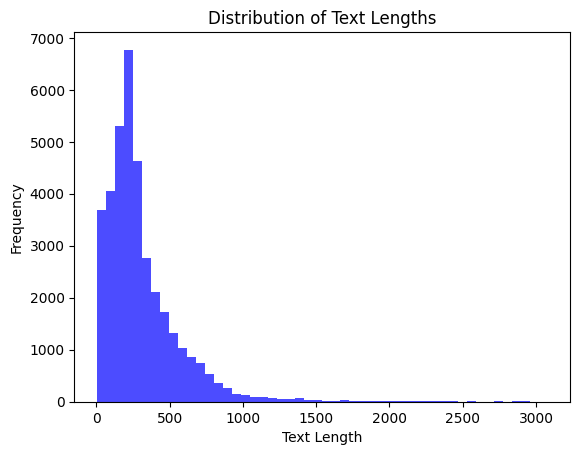

Mean Length: 309.46
Median Length: 239.00
90th Percentile: 623.00
Maximum Length: 3081.00


In [5]:
text_lengths = train_texts.apply(lambda x: len(str(x).split()))

import matplotlib.pyplot as plt
import numpy as np

plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

print(f"Mean Length: {np.mean(text_lengths):.2f}")
print(f"Median Length: {np.median(text_lengths):.2f}")
print(f"90th Percentile: {np.percentile(text_lengths, 90):.2f}")
print(f"Maximum Length: {np.max(text_lengths):.2f}")

In [6]:
from NewsDatasetLSTM import NewsDatasetLSTM
from torch.utils.data import DataLoader

max_len = 623 
# Instantiate datasets
train_dataset = NewsDatasetLSTM(train_texts, train_labels, mod, max_len=max_len)
val_dataset = NewsDatasetLSTM(val_texts, val_labels, mod, max_len=max_len)
test_dataset = NewsDatasetLSTM(test_texts, test_labels, mod, max_len=max_len)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
num_negatives = len(df[df['label'] == 0])
num_positives = len(df[df['label'] == 1])
class_counts = [num_negatives, num_positives]

results = train_evaluate_and_test_models(class_counts,train_loader, val_loader, test_loader, epochs=10)


Training Model 1 (LSTM with Attention)


Evaluating: 100%|██████████| 193/193 [00:26<00:00,  7.22it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 1/10
 Train Loss: 0.8271
 Val Loss: 0.6565
 Val Accuracy: 0.6836
 Val F1 Score: 0.7155
 Precision: 0.5913
 Recall: 0.9056
 Val AUC-ROC: 0.8514



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  7.06it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 2/10
 Train Loss: 0.5978
 Val Loss: 0.4602
 Val Accuracy: 0.8410
 Val F1 Score: 0.8331
 Precision: 0.7729
 Recall: 0.9034
 Val AUC-ROC: 0.9147



Evaluating: 100%|██████████| 193/193 [00:26<00:00,  7.19it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 3/10
 Train Loss: 0.4553
 Val Loss: 0.3113
 Val Accuracy: 0.8752
 Val F1 Score: 0.8695
 Precision: 0.8043
 Recall: 0.9462
 Val AUC-ROC: 0.9528



Evaluating: 100%|██████████| 193/193 [00:25<00:00,  7.47it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 4/10
 Train Loss: 0.3789
 Val Loss: 0.3084
 Val Accuracy: 0.8727
 Val F1 Score: 0.8697
 Precision: 0.7899
 Recall: 0.9674
 Val AUC-ROC: 0.9575



Evaluating: 100%|██████████| 193/193 [00:25<00:00,  7.50it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 5/10
 Train Loss: 0.3447
 Val Loss: 0.2589
 Val Accuracy: 0.9016
 Val F1 Score: 0.8954
 Precision: 0.8397
 Recall: 0.9591
 Val AUC-ROC: 0.9691



Evaluating: 100%|██████████| 193/193 [00:25<00:00,  7.47it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 6/10
 Train Loss: 0.3218
 Val Loss: 0.2430
 Val Accuracy: 0.9122
 Val F1 Score: 0.9063
 Precision: 0.8536
 Recall: 0.9659
 Val AUC-ROC: 0.9730



Evaluating: 100%|██████████| 193/193 [00:26<00:00,  7.27it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 7/10
 Train Loss: 0.2879
 Val Loss: 0.2078
 Val Accuracy: 0.9300
 Val F1 Score: 0.9228
 Precision: 0.8949
 Recall: 0.9524
 Val AUC-ROC: 0.9802



Evaluating: 100%|██████████| 193/193 [00:26<00:00,  7.36it/s]


Performance did not improve: Current metric: 0.2115, best metric: 0.2078 Counter: 1/4
Epoch 8/10
 Train Loss: 0.2582
 Val Loss: 0.2115
 Val Accuracy: 0.9271
 Val F1 Score: 0.9208
 Precision: 0.8812
 Recall: 0.9641
 Val AUC-ROC: 0.9793



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.67it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 9/10
 Train Loss: 0.2409
 Val Loss: 0.1935
 Val Accuracy: 0.9353
 Val F1 Score: 0.9288
 Precision: 0.8993
 Recall: 0.9602
 Val AUC-ROC: 0.9823



Evaluating: 100%|██████████| 193/193 [00:37<00:00,  5.15it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 10/10
 Train Loss: 0.2250
 Val Loss: 0.1928
 Val Accuracy: 0.9361
 Val F1 Score: 0.9294
 Precision: 0.9027
 Recall: 0.9578
 Val AUC-ROC: 0.9830


Saving final model state...
Final checkpoint saved at checkpoints\LSTMWithAttention_final.pt
Final model saved at: checkpoints\LSTMWithAttention_final.pt

Testing with best model checkpoint...
Checkpoint loaded from checkpoints\LSTMWithAttention_best.pt
Resuming from epoch 10


Evaluating: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]



Test Results:
Loss: 0.2114
Accuracy: 0.9288
F1 Score: 0.9215
Precision: 0.8923
Recall: 0.9527
ROC AUC: 0.9810


Training Model 2 (LSTM without Attention)


Evaluating: 100%|██████████| 193/193 [00:38<00:00,  5.05it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 1/10
 Train Loss: 0.7921
 Val Loss: 0.7711
 Val Accuracy: 0.4736
 Val F1 Score: 0.6165
 Precision: 0.4533
 Recall: 0.9633
 Val AUC-ROC: 0.5290



Evaluating: 100%|██████████| 193/193 [00:20<00:00,  9.23it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 2/10
 Train Loss: 0.7783
 Val Loss: 0.7671
 Val Accuracy: 0.4770
 Val F1 Score: 0.6190
 Precision: 0.4551
 Recall: 0.9672
 Val AUC-ROC: 0.5353



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.87it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 3/10
 Train Loss: 0.7665
 Val Loss: 0.7594
 Val Accuracy: 0.5659
 Val F1 Score: 0.1102
 Precision: 0.5524
 Recall: 0.0612
 Val AUC-ROC: 0.7081



Evaluating: 100%|██████████| 193/193 [00:22<00:00,  8.68it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 4/10
 Train Loss: 0.6145
 Val Loss: 0.5538
 Val Accuracy: 0.7991
 Val F1 Score: 0.7290
 Precision: 0.8940
 Recall: 0.6155
 Val AUC-ROC: 0.8528



Evaluating: 100%|██████████| 193/193 [00:38<00:00,  4.96it/s]


Performance did not improve: Current metric: 0.5836, best metric: 0.5538 Counter: 1/4
Epoch 5/10
 Train Loss: 0.5367
 Val Loss: 0.5836
 Val Accuracy: 0.7691
 Val F1 Score: 0.6676
 Precision: 0.9078
 Recall: 0.5279
 Val AUC-ROC: 0.8360



Evaluating: 100%|██████████| 193/193 [00:40<00:00,  4.80it/s]


Performance did not improve: Current metric: 0.6318, best metric: 0.5538 Counter: 2/4
Epoch 6/10
 Train Loss: 0.5604
 Val Loss: 0.6318
 Val Accuracy: 0.7647
 Val F1 Score: 0.7346
 Precision: 0.7277
 Recall: 0.7416
 Val AUC-ROC: 0.8142



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  9.17it/s]


Performance did not improve: Current metric: 0.6156, best metric: 0.5538 Counter: 3/4
Epoch 7/10
 Train Loss: 0.5727
 Val Loss: 0.6156
 Val Accuracy: 0.7417
 Val F1 Score: 0.7441
 Precision: 0.6586
 Recall: 0.8551
 Val AUC-ROC: 0.7818



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  9.02it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 8/10
 Train Loss: 0.5541
 Val Loss: 0.5398
 Val Accuracy: 0.8132
 Val F1 Score: 0.7945
 Precision: 0.7687
 Recall: 0.8221
 Val AUC-ROC: 0.8465



Evaluating: 100%|██████████| 193/193 [00:29<00:00,  6.51it/s]


Performance did not improve: Current metric: 0.5440, best metric: 0.5398 Counter: 1/4
Epoch 9/10
 Train Loss: 0.5525
 Val Loss: 0.5440
 Val Accuracy: 0.8152
 Val F1 Score: 0.7858
 Precision: 0.8002
 Recall: 0.7720
 Val AUC-ROC: 0.8534



Evaluating: 100%|██████████| 193/193 [00:39<00:00,  4.90it/s]


Performance did not improve: Current metric: 0.5931, best metric: 0.5398 Counter: 2/4
Epoch 10/10
 Train Loss: 0.5597
 Val Loss: 0.5931
 Val Accuracy: 0.7753
 Val F1 Score: 0.7102
 Precision: 0.8193
 Recall: 0.6267
 Val AUC-ROC: 0.8465


Saving final model state...
Final checkpoint saved at checkpoints\LSTMWithoutAttention_final.pt
Final model saved at: checkpoints\LSTMWithoutAttention_final.pt

Testing with best model checkpoint...
Checkpoint loaded from checkpoints\LSTMWithoutAttention_best.pt
Resuming from epoch 8


Evaluating: 100%|██████████| 194/194 [00:38<00:00,  5.03it/s]



Test Results:
Loss: 0.5456
Accuracy: 0.8095
F1 Score: 0.7911
Precision: 0.7627
Recall: 0.8218
ROC AUC: 0.8433



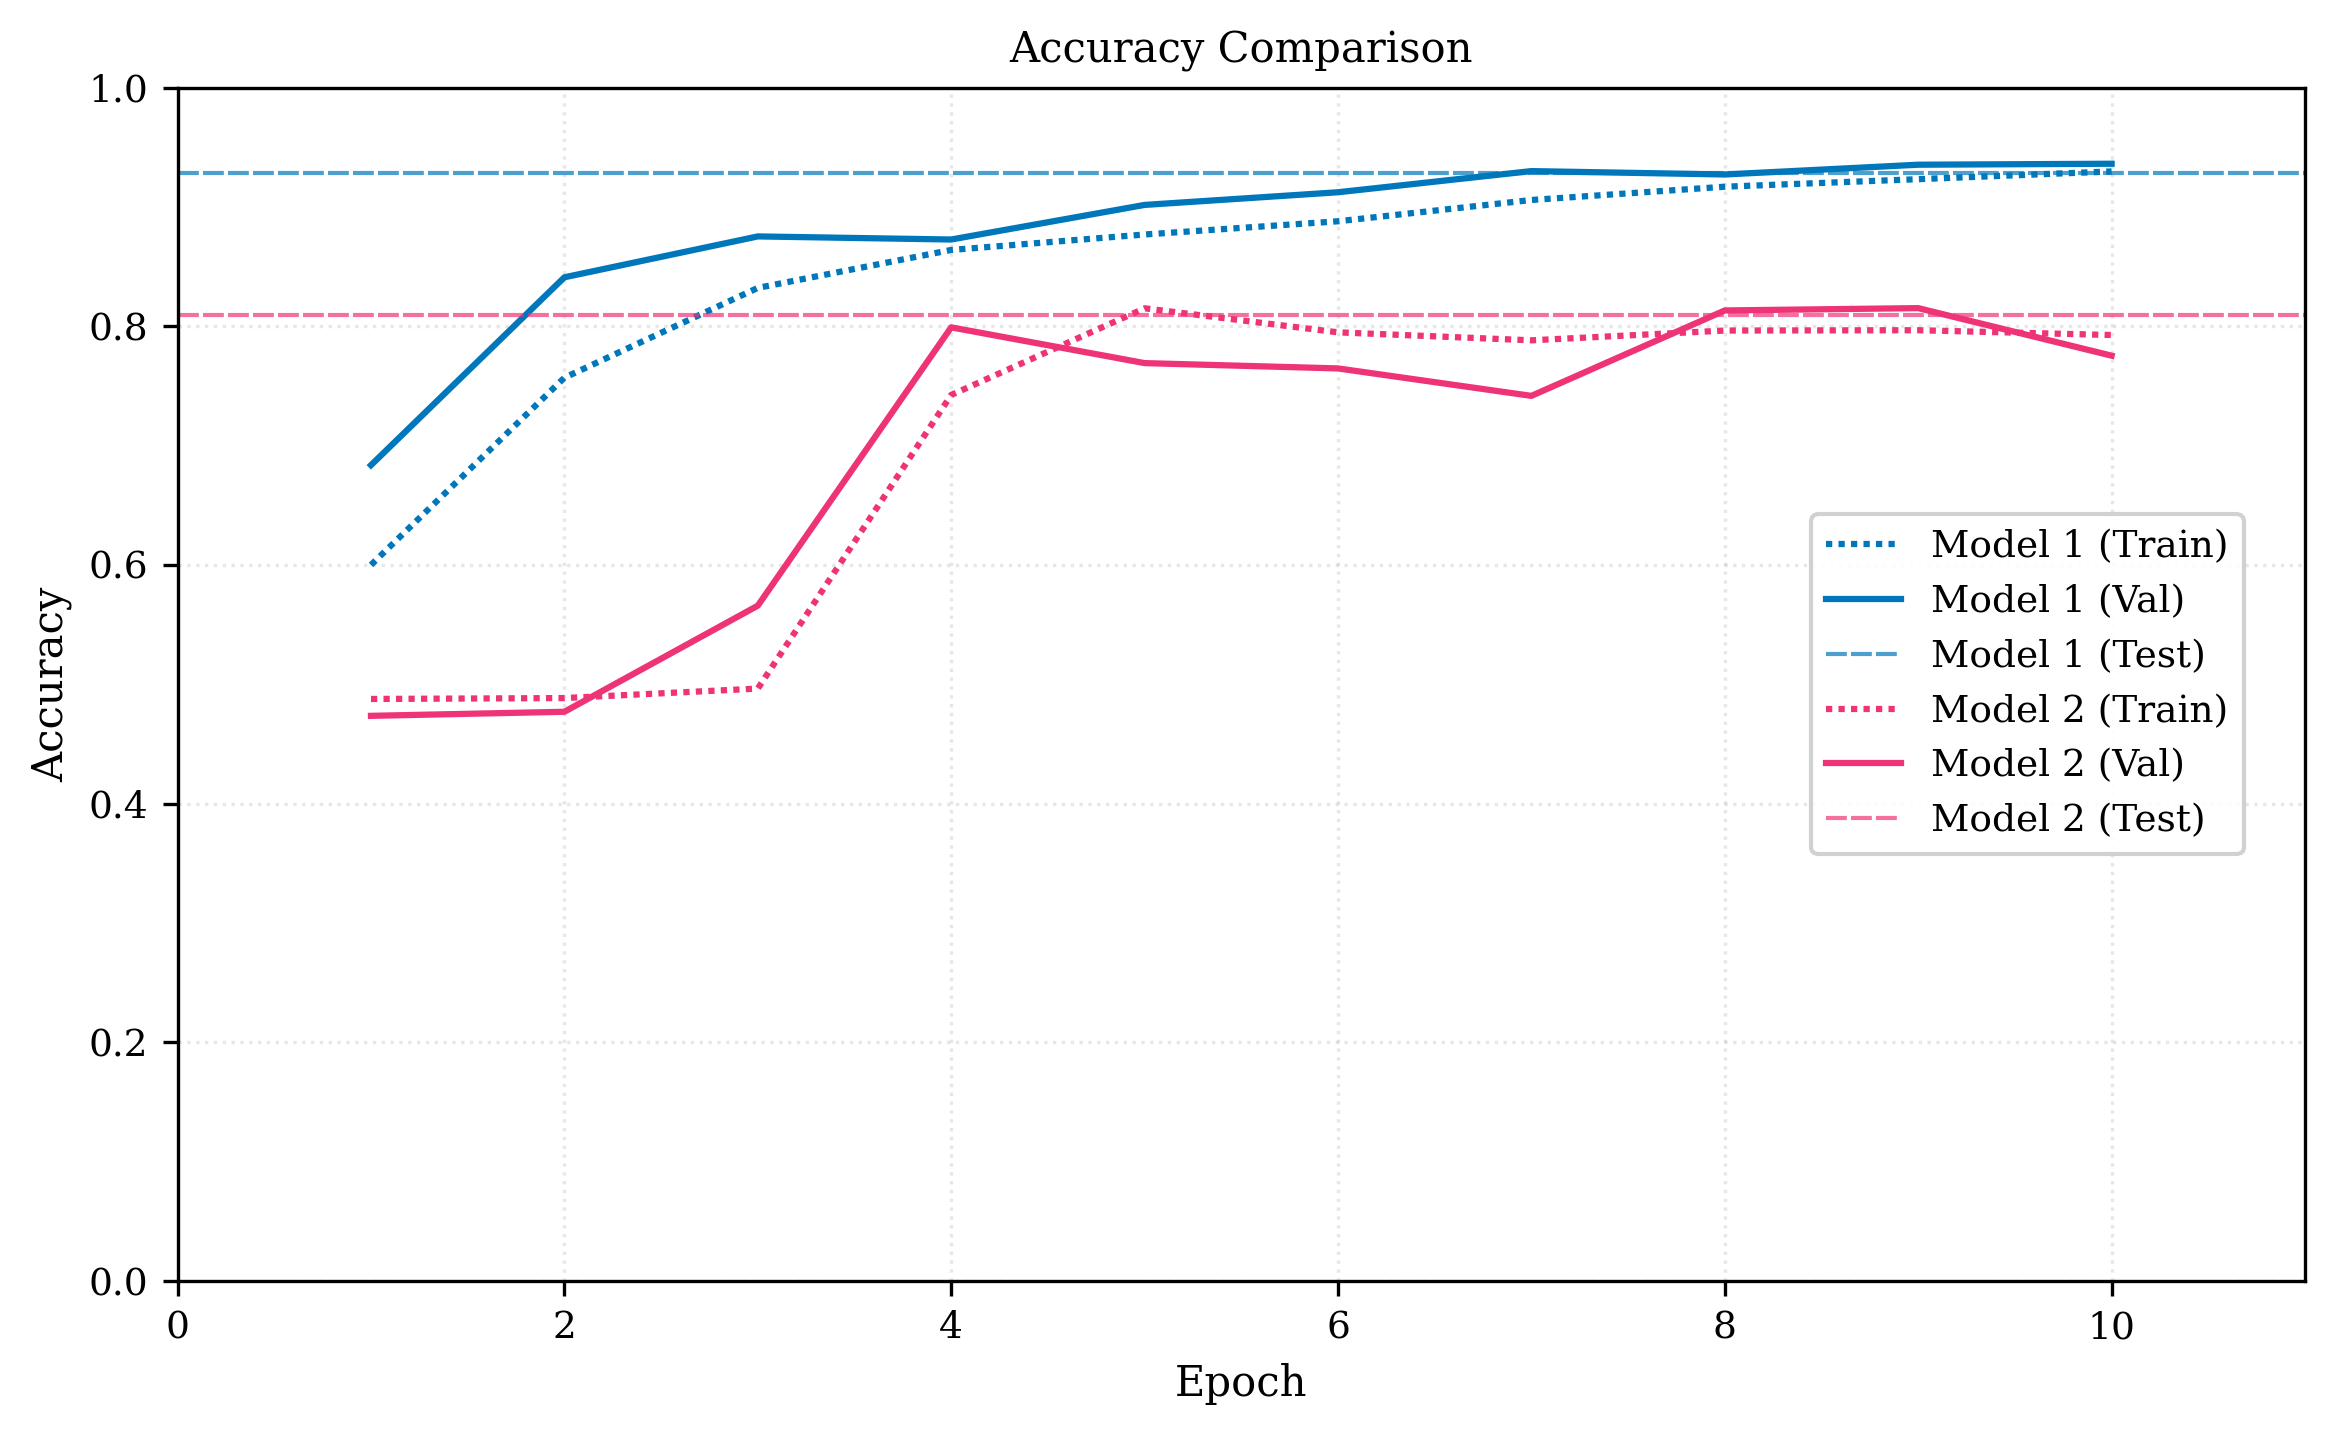

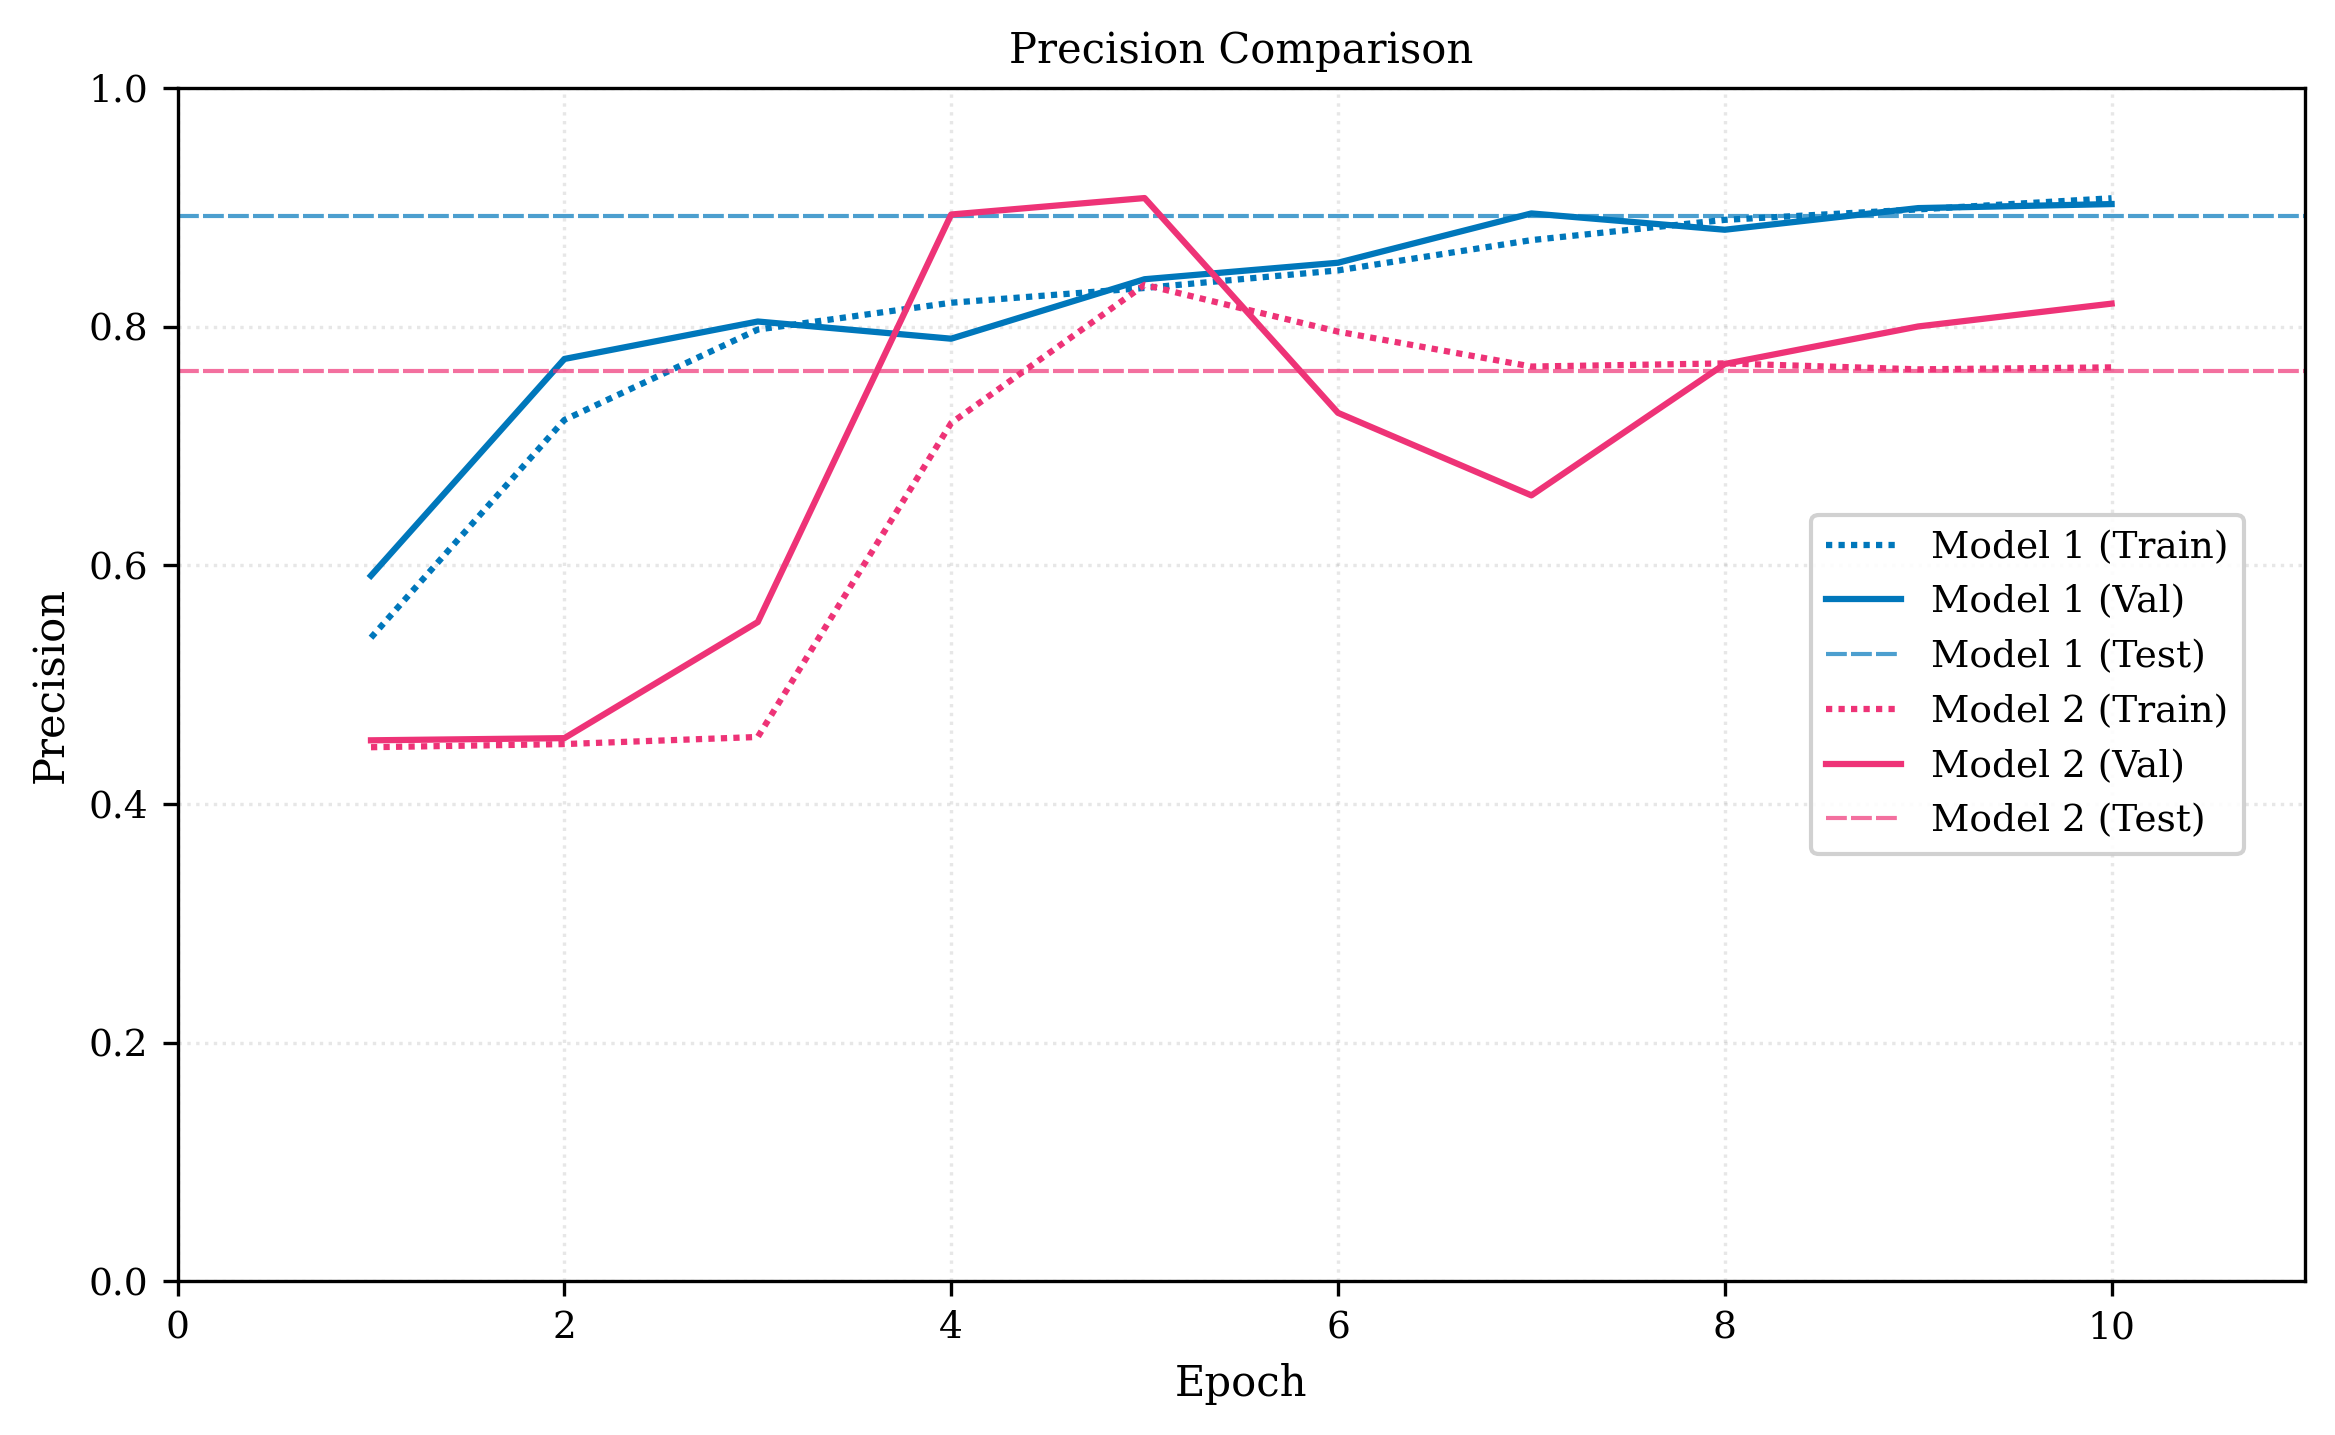

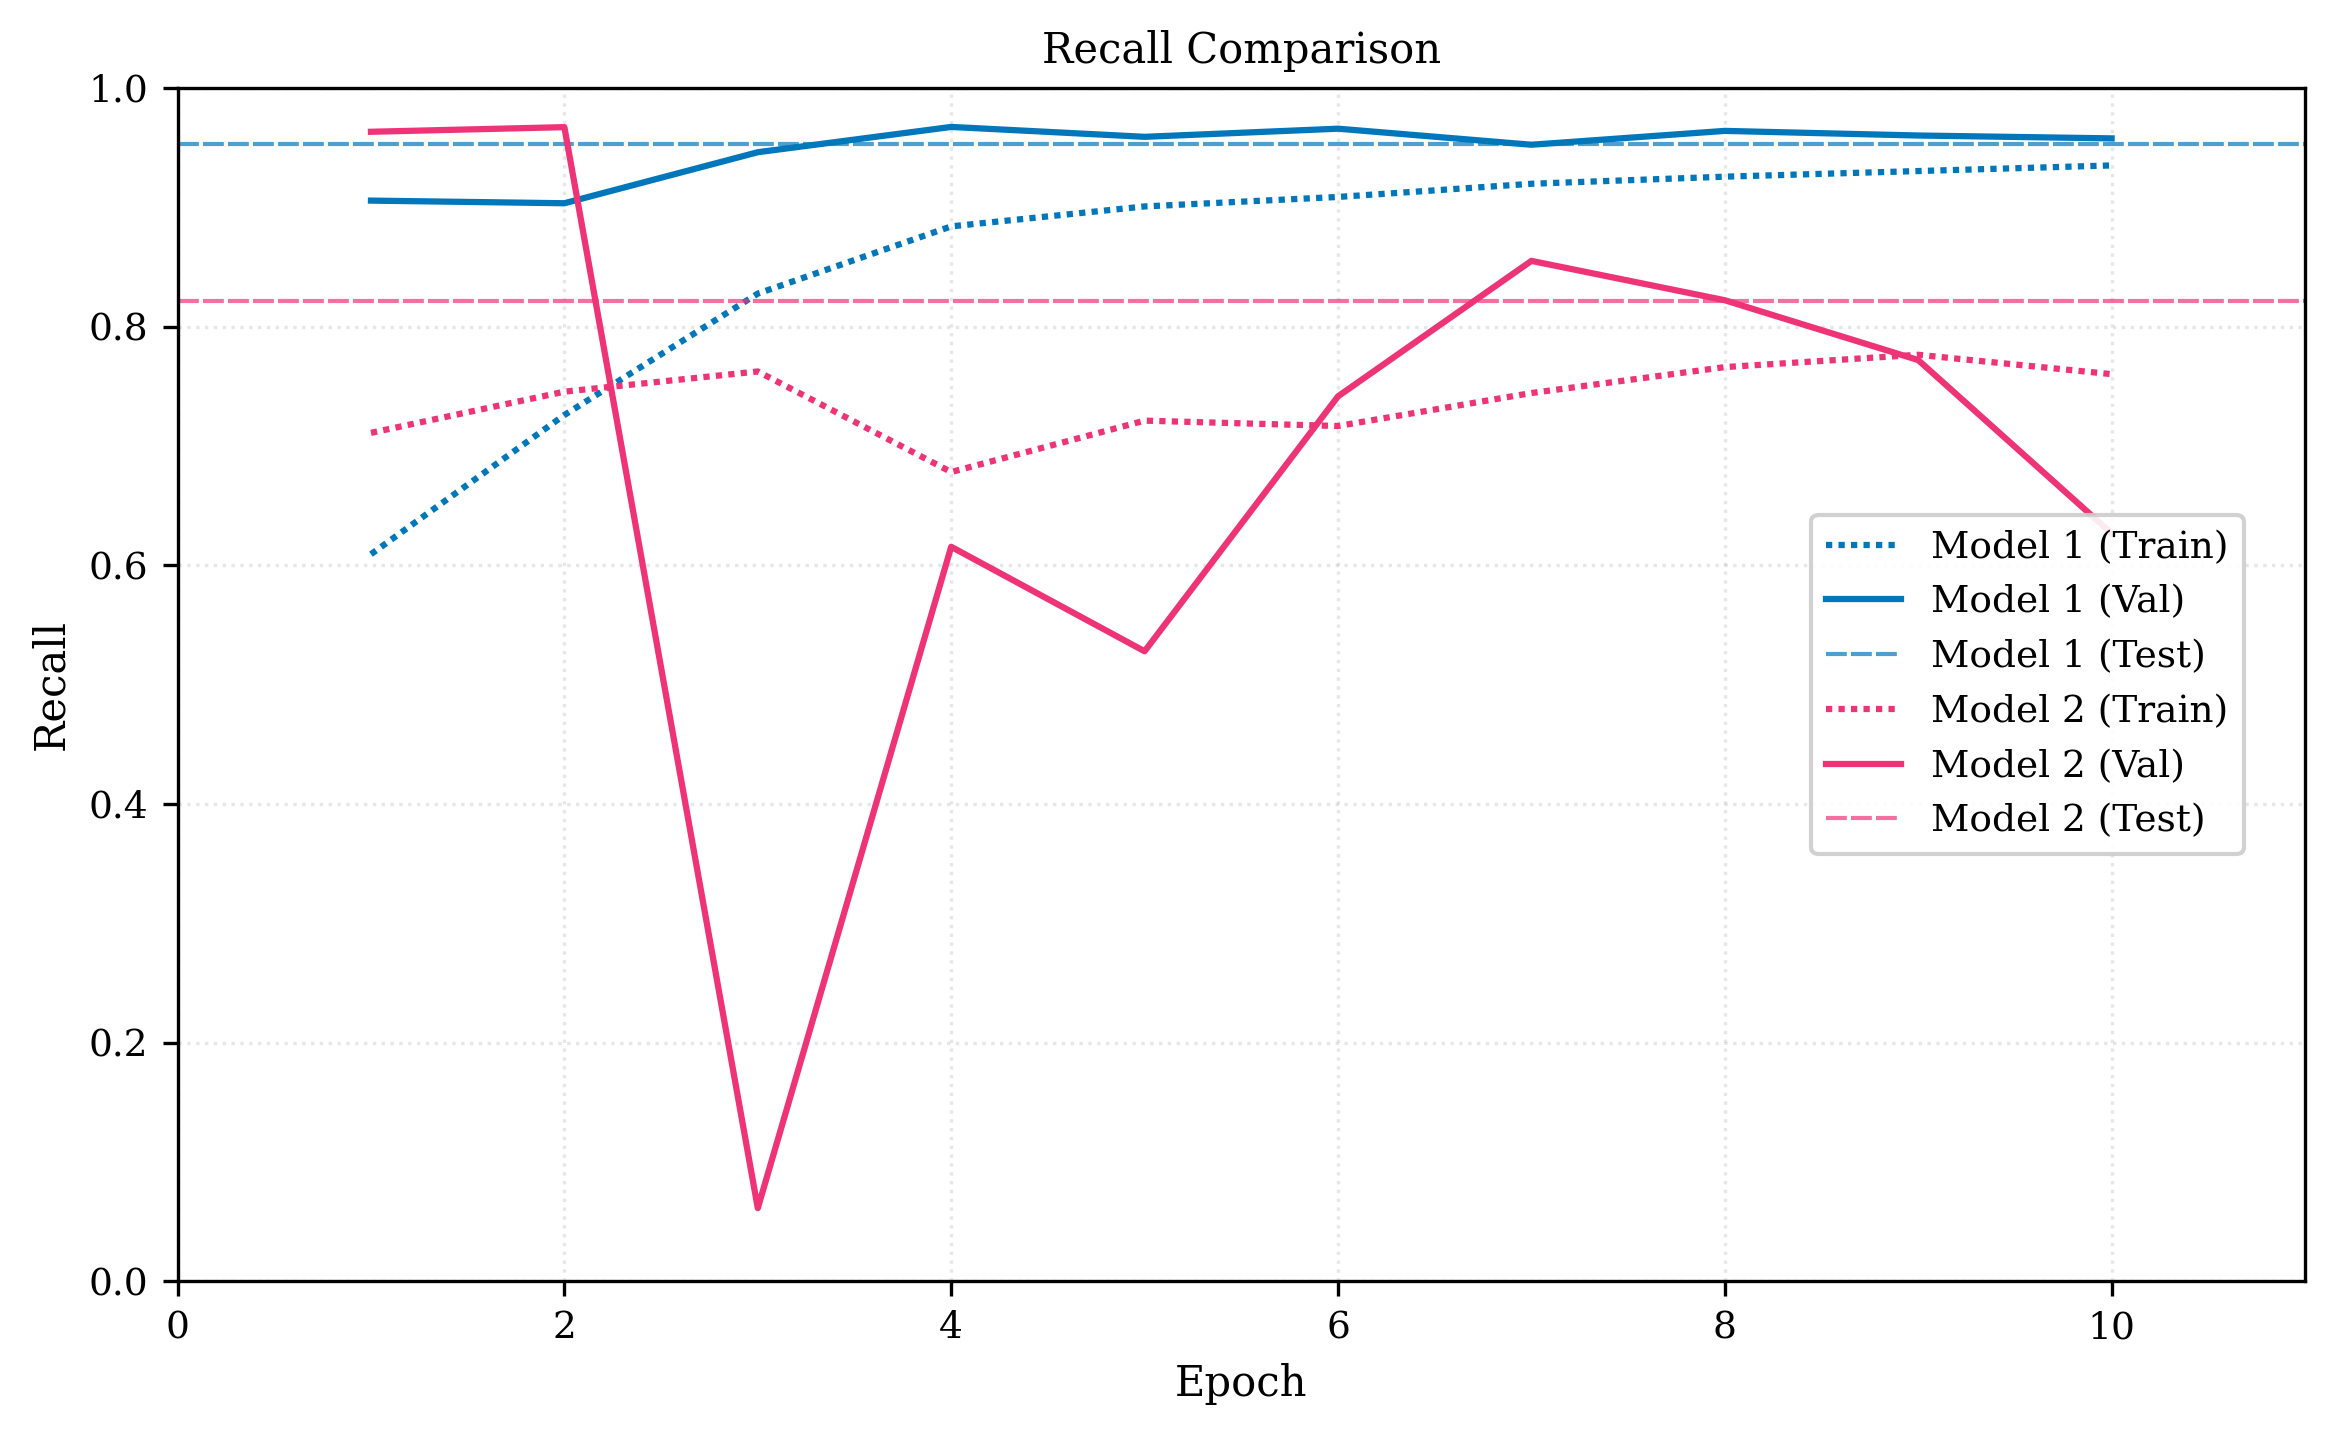

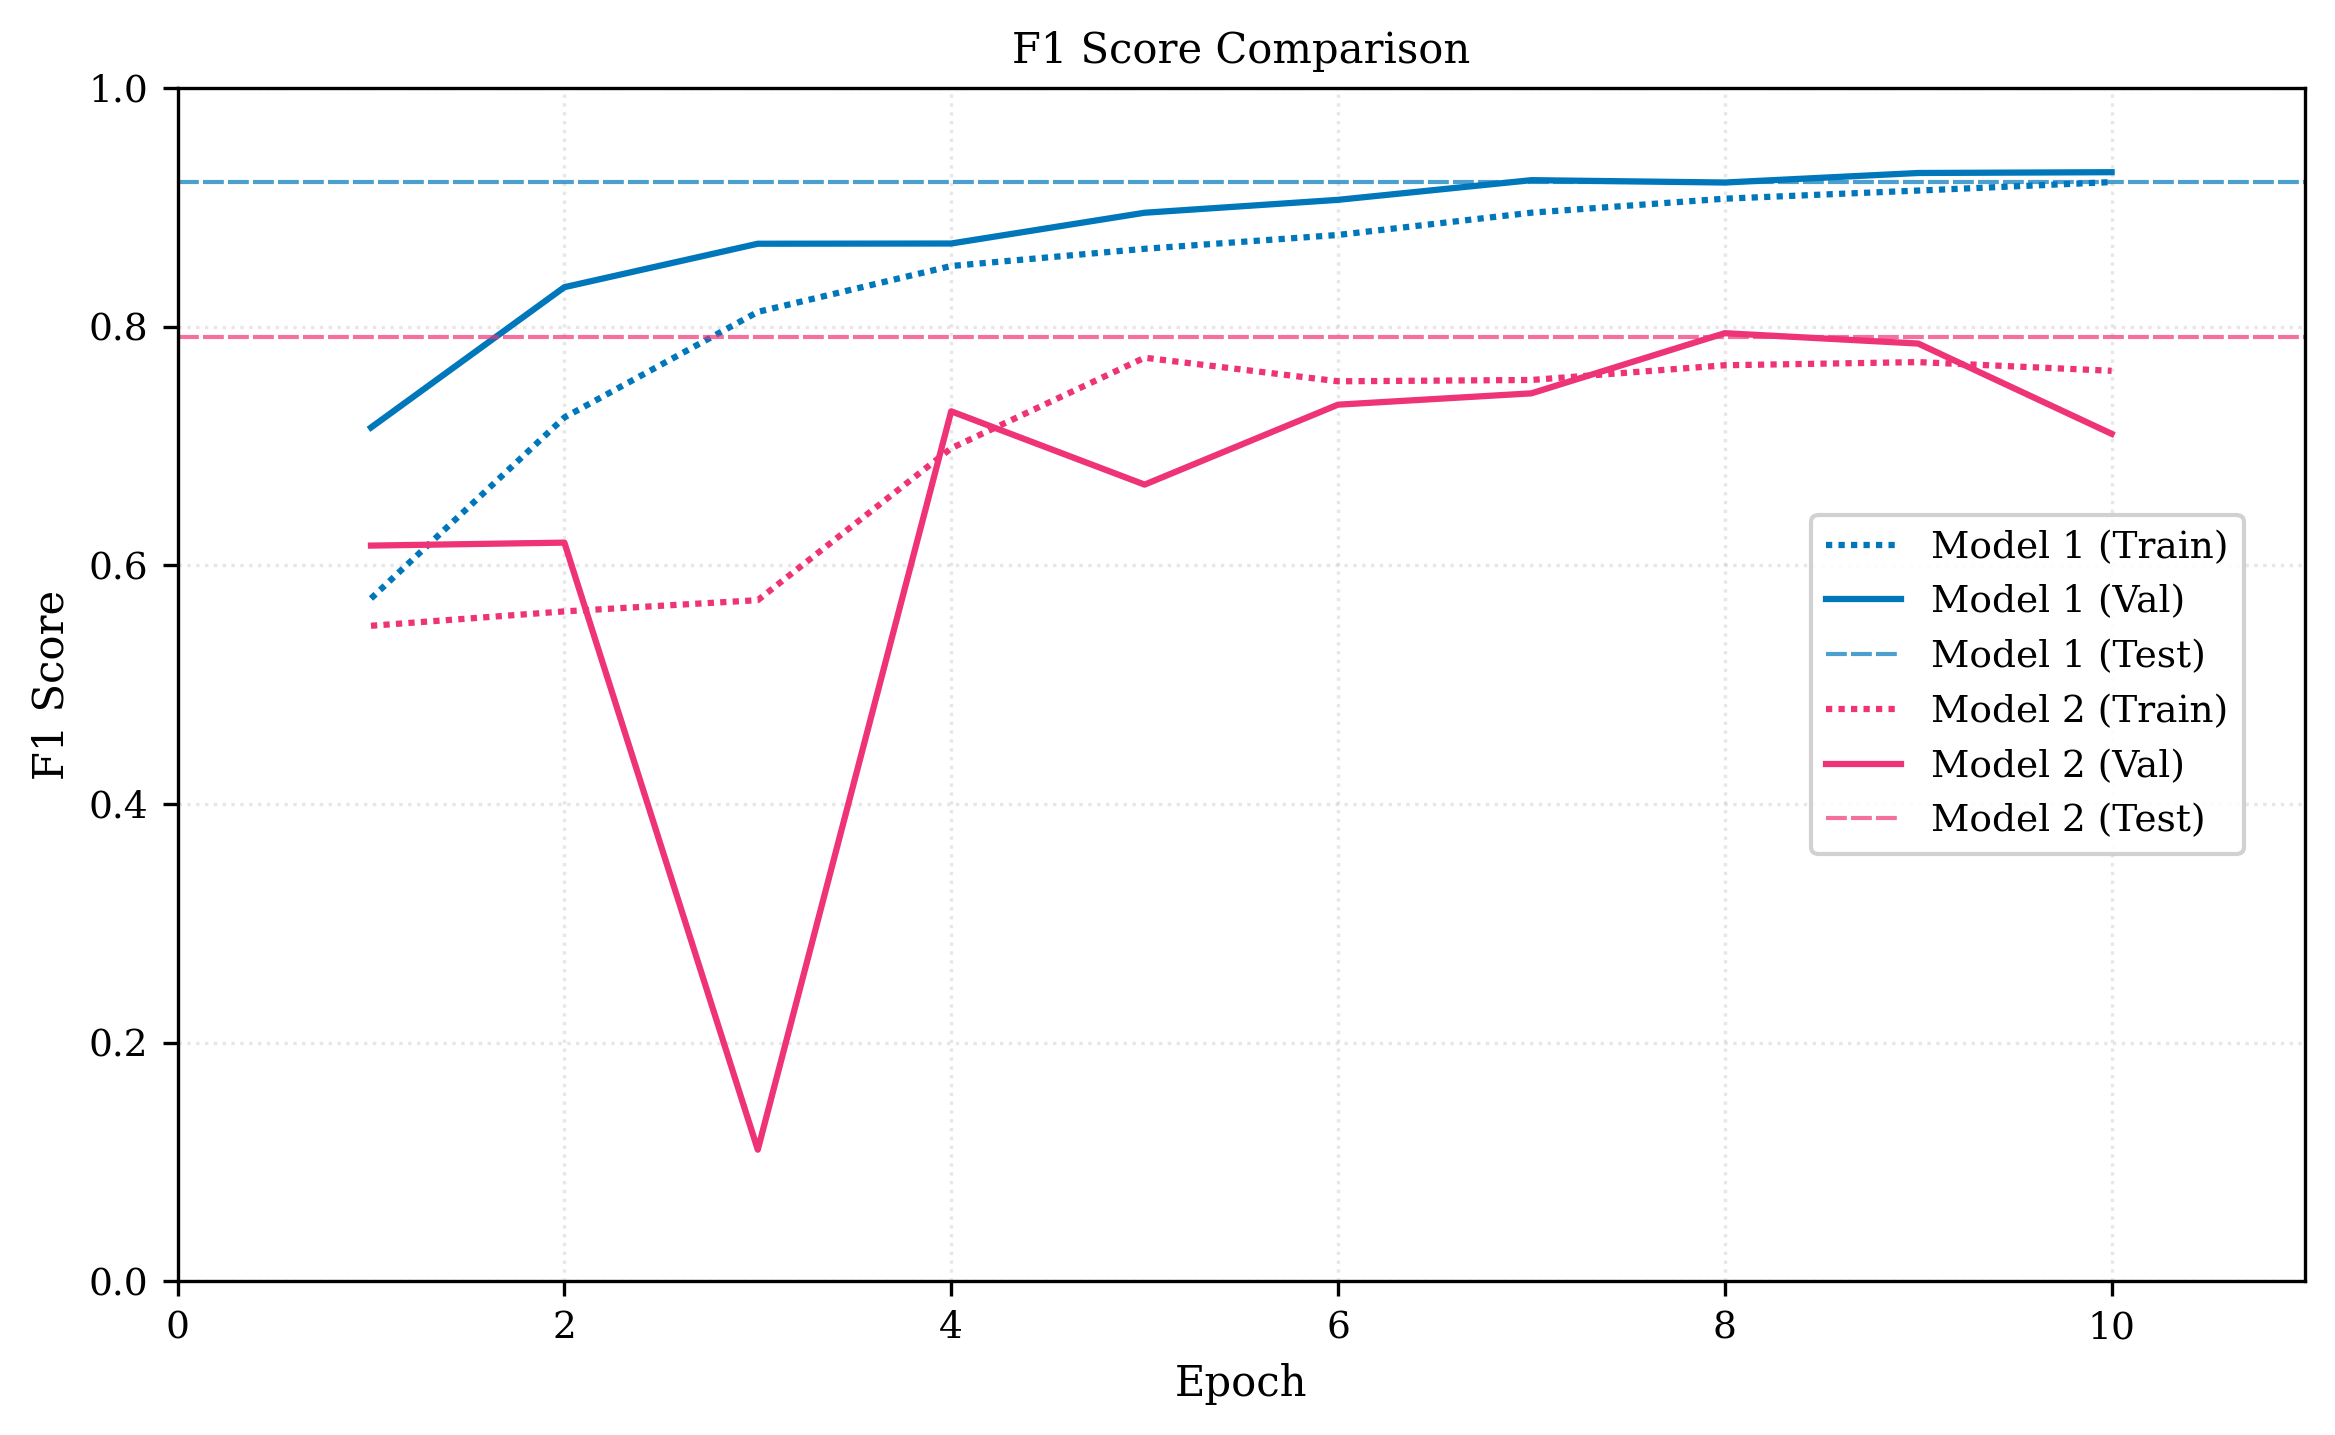

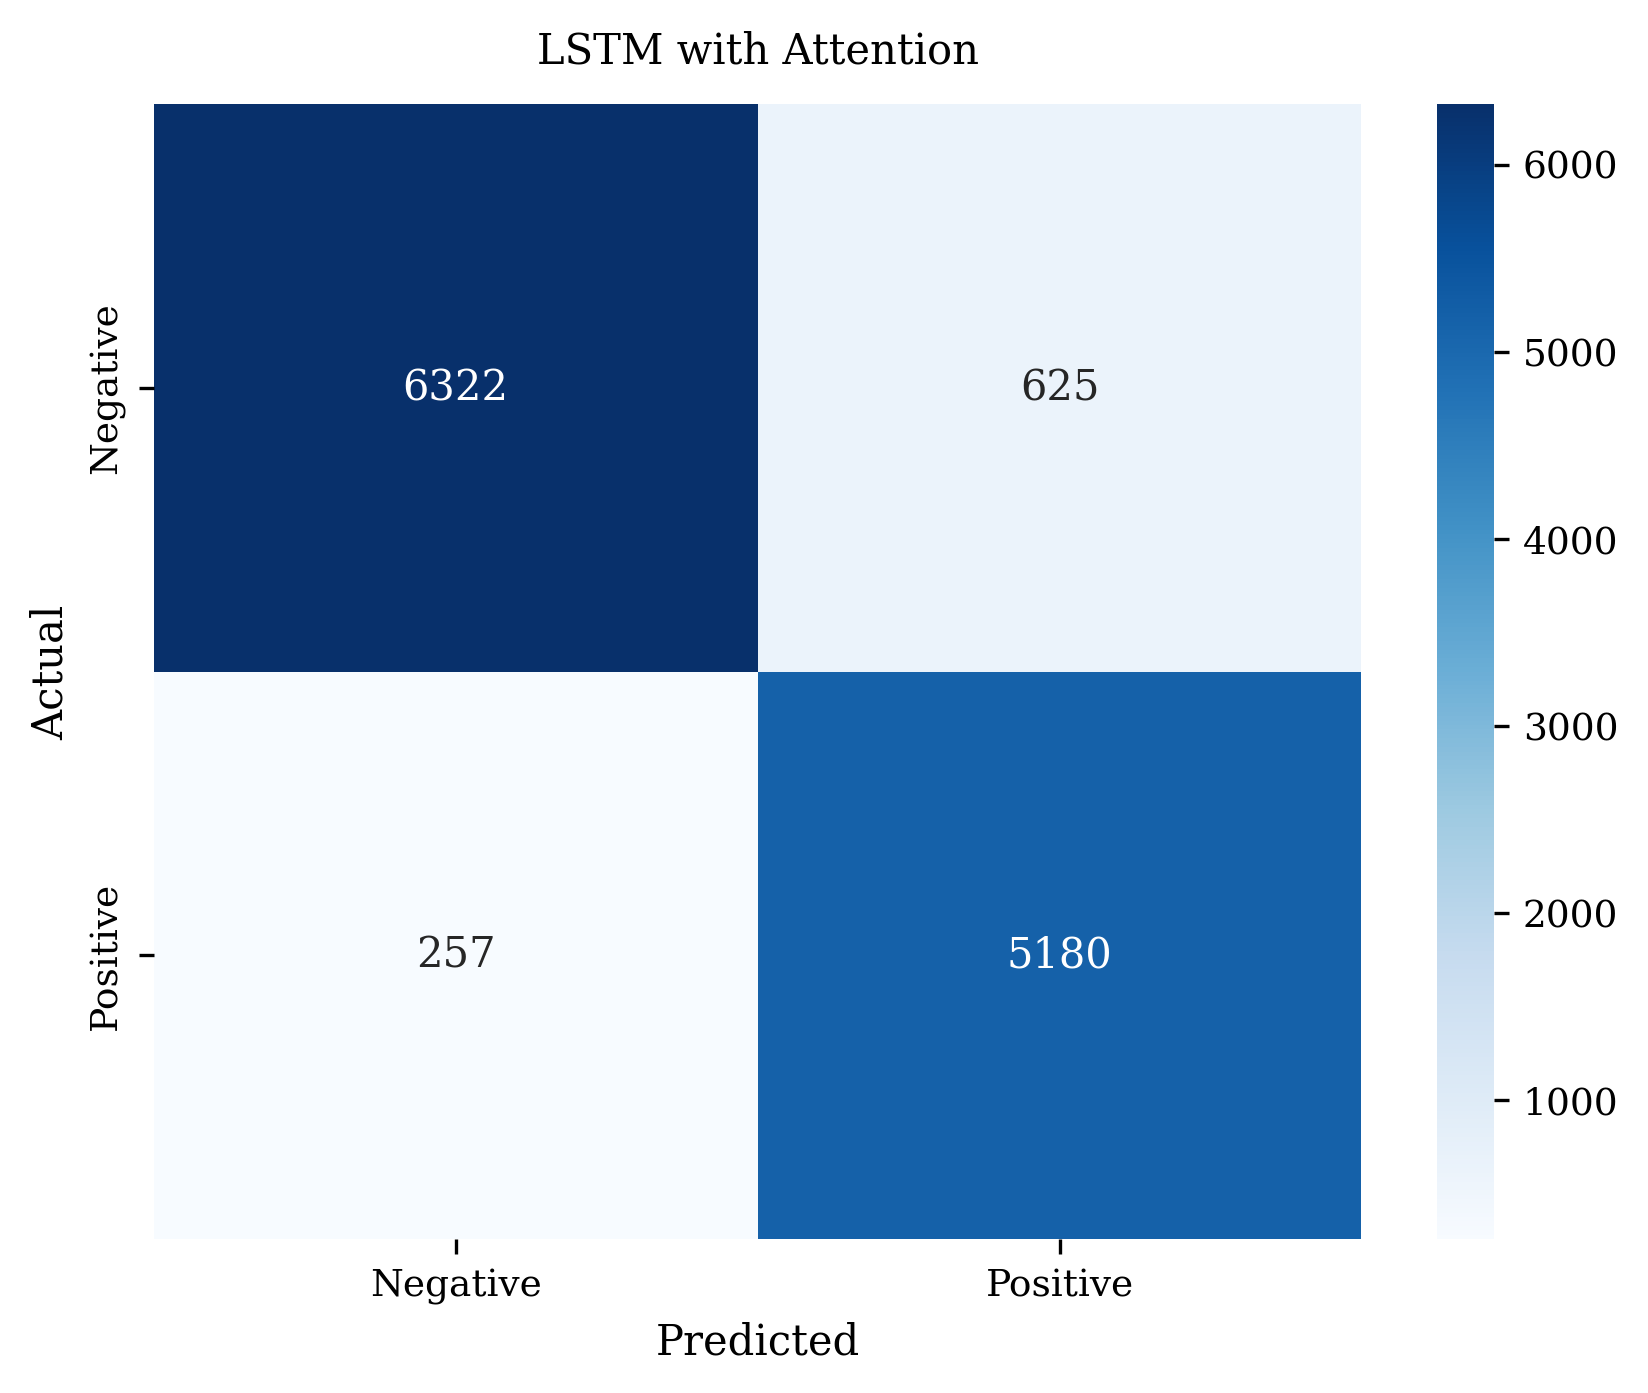

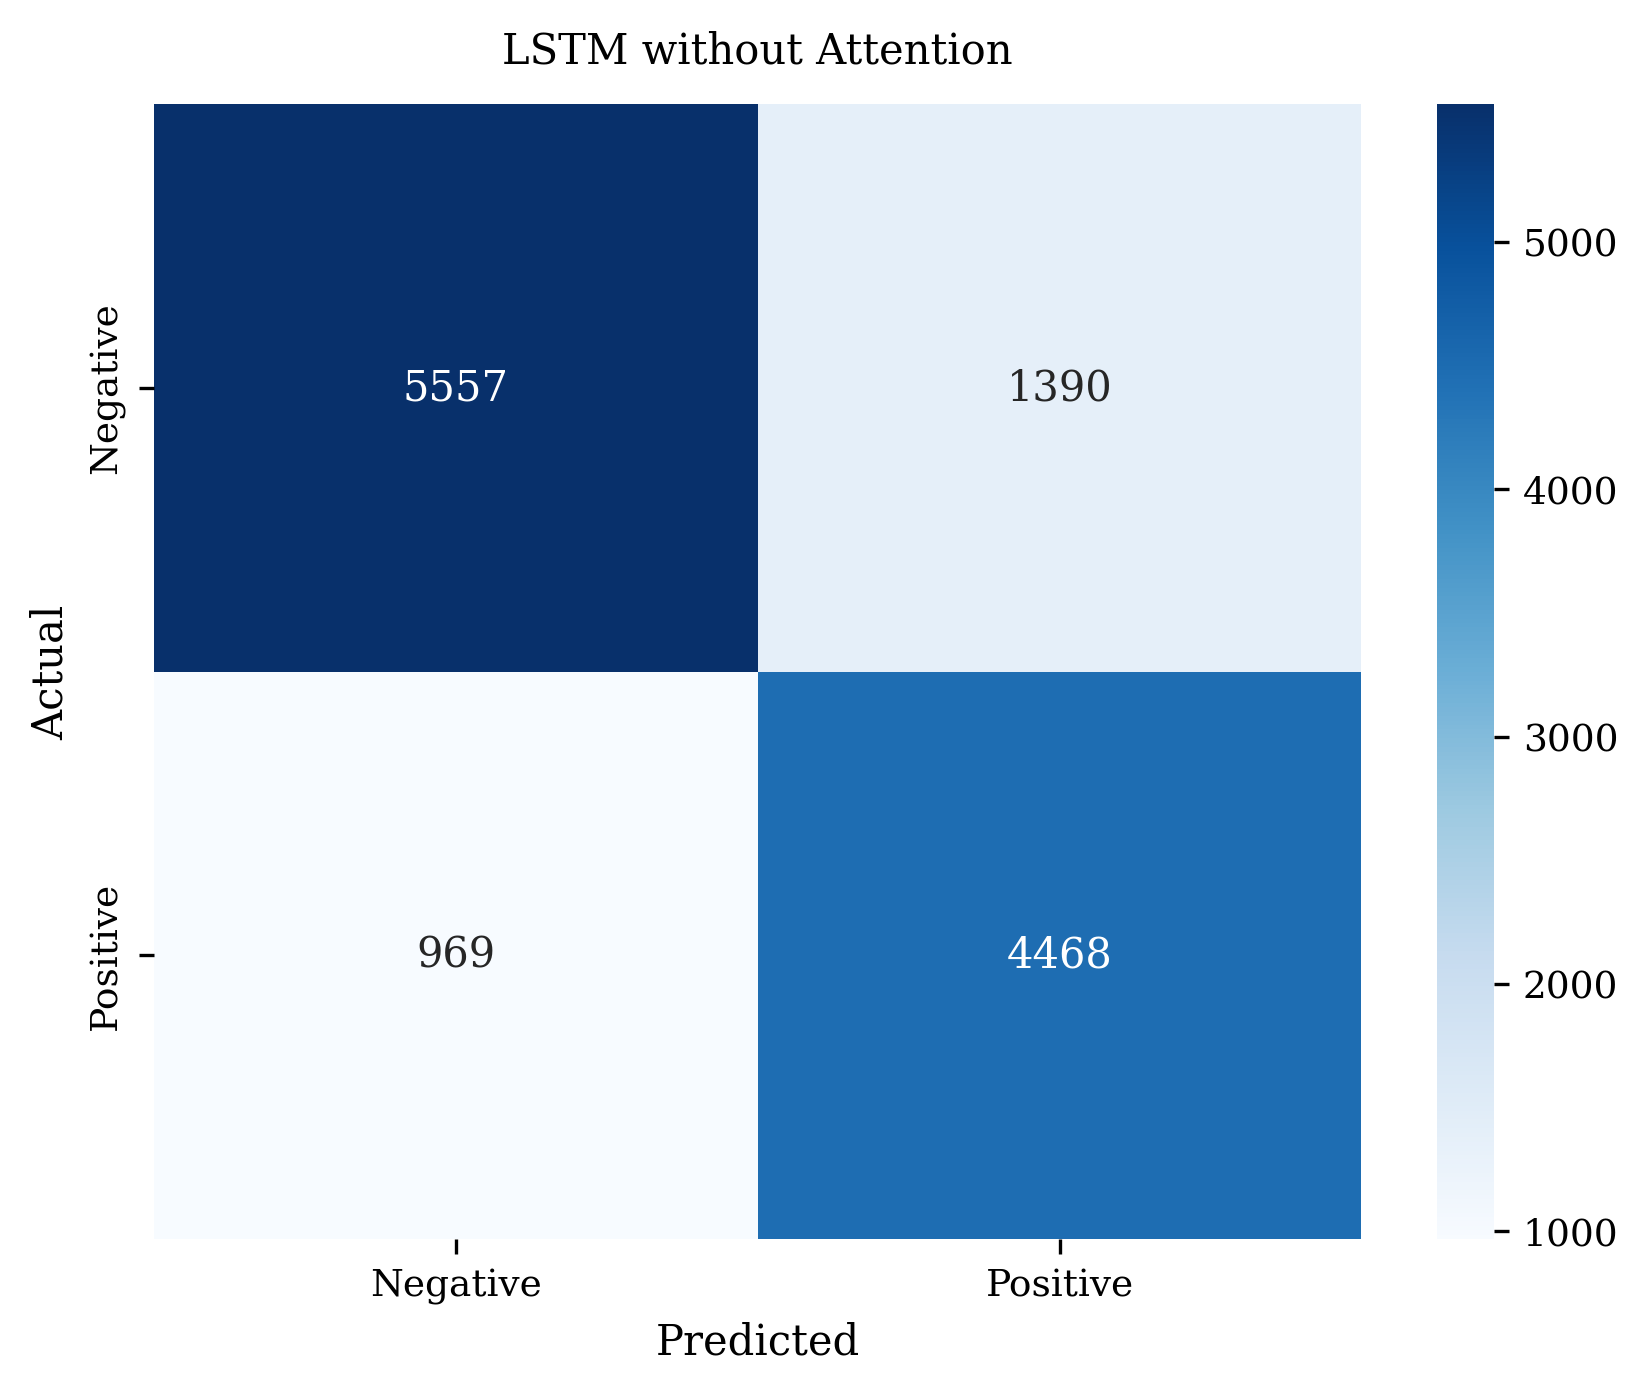

In [8]:
visualize_results(results)

In [12]:
def compare_models(results):
    print("\nModel Comparison:")
    print("-" * 50)

    # Compare training/validation metrics
    print("\nTraining/Validation Metrics (Key Values):")
    metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score']
    
    for metric in metrics_to_compare:
        print(f"\n{metric.upper()}:")
        
        for model_name in results:
            val_scores = results[model_name]['training_metrics'][metric]['val']
            final_score = val_scores[-1]
            best_score = max(val_scores)
            mean_score = np.mean(val_scores)
            
            print(f"{model_name}: Final: {final_score:.4f}, Best: {best_score:.4f}, Mean: {mean_score:.4f}")
    
    # Compare test metrics (display only final score)
    print("\nTest Metrics (Final Score):")
    for metric in metrics_to_compare:
        print(f"\n{metric.upper()}:")
        
        for model_name in results:
            test_score = results[model_name]['test_metrics'][metric]
            print(f"{model_name}: {test_score:.4f}")
            
compare_models(results)



Model Comparison:
--------------------------------------------------

Training/Validation Metrics (Key Values):

ACCURACY:
Model 1: Final: 0.9436, Best: 0.9436, Mean: 0.8901
Model 2: Final: 0.7868, Best: 0.8283, Mean: 0.7109

PRECISION:
Model 1: Final: 0.9174, Best: 0.9189, Mean: 0.8471
Model 2: Final: 0.7230, Best: 0.8994, Mean: 0.6945

RECALL:
Model 1: Final: 0.9578, Best: 0.9591, Mean: 0.9330
Model 2: Final: 0.8339, Best: 0.9665, Mean: 0.7418

F1_SCORE:
Model 1: Final: 0.9371, Best: 0.9371, Mean: 0.8858
Model 2: Final: 0.7745, Best: 0.7926, Mean: 0.6747

Test Metrics (Final Score):

ACCURACY:
Model 1: 0.9347
Model 2: 0.8250

PRECISION:
Model 1: 0.9020
Model 2: 0.8419

RECALL:
Model 1: 0.9549
Model 2: 0.7405

F1_SCORE:
Model 1: 0.9277
Model 2: 0.7879
